In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.optimize import fsolve
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/cwx/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


1. The goal of this homework exercise is to replicate the Black-Derman-Toy example presented in class. The data for the volatility of r is in the first sheet of the
accompanying spreadsheet. The second sheet has the term structure data (D(T ))
function. The third sheet has my BDT tree.


In [2]:
vol_data = pd.read_excel("Homework_6_Data.xlsx", sheet_name="Volatility Data", skiprows=2)
disc_data = pd.read_excel("Homework_6_Data.xlsx", sheet_name="Discount Factors", skiprows = 3)

vol_data.columns = ["Maturity", "Volatility"]
vol_data.set_index('Maturity',inplace=True,drop=True)
vol_data.loc[0.0,'Volatility'] = 0
vol_data.sort_index(inplace=True)

disc_data.columns = ["Maturity", "Discount Rate"]
disc_data.set_index('Maturity',inplace=True,drop=True)

2. Note that exactly replicating my numbers is not required. Each program has its
own particular features and quirks and it is difficult to get two numerical programs
programmed to give exactly the same results.


3. The best approach may be to write a program to solve at each date for the correct
drift or r∗ that matches the discount bond price. This tree could also be built in
Excel using the solver algorithm, but this could be a little tedious since you have to
manually use the solver 20 times. It’s your call on how to proceed.


In [3]:
class BDTtree:
    def __init__(self, _vol,_disc,_T):
        self.vol = _vol
        self.disc = _disc
        self.T = _T

        self.ts = np.arange(0, self.T+0.5, 0.5).tolist()
        self.r_tree = pd.DataFrame(np.nan,index=range(1, 15*2+1),columns=self.ts[:-1])

    def discount(self, r, r_tree_new):
        t = r_tree_new.columns[-1]
        r_tree_new[t] = [r*np.exp(-2*self.vol.loc[t]*np.sqrt(0.5)*i) for i in range(0, len(r_tree_new), 1)]
        disc_tree = 1/(1+r_tree_new/2)

        cf_tree = pd.DataFrame(np.nan,index=range(1, len(r_tree_new)+2),columns=self.ts[:len(r_tree_new)+1])
        cf_tree[t+0.5] = 1
        for i in self.ts[len(r_tree_new)-1::-1]:
            cf_tree[i] = (disc_tree[i]*cf_tree[i+0.5] + disc_tree[i]*cf_tree.shift(-1)[i+0.5])/2

        return cf_tree.iloc[0,0].values[0]
    
    def square_err(self, r, r_tree_new):
        t = r_tree_new.columns[-1]
        err = self.discount(r, r_tree_new)-self.disc.loc[t+0.5].values[0]
        return err**2
    
    def generate_tree(self):
        for n,t in enumerate(self.r_tree.columns):
            ts_new = self.ts[:n+1]
            r_tree_new = self.r_tree[ts_new][:n+1]

            r = fsolve(self.square_err, 0.01, args=(r_tree_new))[0]

            self.r_tree[t][:n+1] = [r*np.exp(-2*self.vol.loc[t]*np.sqrt(0.5)*i) for i in range(0, n+1, 1)]
        return self.r_tree


In [4]:
model = BDTtree(vol_data,disc_data,15)
bdt_tree = model.generate_tree()


In [5]:
bdt_tree

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
1,0.056605,0.063270,0.072572,0.084125,0.098326,0.114152,0.129116,0.146041,0.162498,0.180818,...,0.425064,0.452156,0.479588,0.499425,0.526511,0.553723,0.581053,0.608522,0.636150,0.664007
2,NaN,0.054926,0.061245,0.069504,0.079532,0.091036,0.102679,0.115811,0.129226,0.144202,...,0.355183,0.378892,0.403017,0.421471,0.445588,0.469945,0.494537,0.519383,0.544502,0.569955
3,NaN,NaN,0.051685,0.057424,0.064330,0.072601,0.081655,0.091838,0.102767,0.115001,...,0.296791,0.317499,0.338672,0.355685,0.377102,0.398843,0.420902,0.443301,0.466057,0.489225
4,NaN,NaN,NaN,0.047444,0.052034,0.057899,0.064936,0.072828,0.081725,0.091713,...,0.247999,0.266053,0.284600,0.300168,0.319143,0.338498,0.358232,0.378364,0.398913,0.419930
5,NaN,NaN,NaN,NaN,0.042088,0.046175,0.051640,0.057752,0.064991,0.073141,...,0.207228,0.222944,0.239161,0.253315,0.270092,0.287284,0.304893,0.322940,0.341443,0.360449
6,NaN,NaN,NaN,NaN,NaN,0.036824,0.041067,0.045798,0.051684,0.058330,...,0.173160,0.186820,0.200976,0.213776,0.228580,0.243818,0.259496,0.275634,0.292252,0.309394
7,NaN,NaN,NaN,NaN,NaN,NaN,0.032658,0.036318,0.041102,0.046518,...,0.144692,0.156549,0.168888,0.180409,0.193448,0.206928,0.220858,0.235258,0.250148,0.265571
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028800,0.032686,0.037098,...,0.120905,0.131183,0.141924,0.152249,0.163716,0.175620,0.187973,0.200796,0.214110,0.227955
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025993,0.029586,...,0.101028,0.109927,0.119264,0.128485,0.138553,0.149049,0.159985,0.171382,0.183264,0.195666
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023595,...,0.084419,0.092115,0.100223,0.108430,0.117258,0.126498,0.136164,0.146278,0.156862,0.167952


4. Once the tree is built, compute the expected value as of time zero, of the value of
r in .50 years, in 1.00 years, etc. out to the last date on the tree. Graph the expected
r value against the horizon. Recall that the expected value of r can be viewed as a
futures rate (Eurodollar futures example). Contrast this with the forward rate for
the same horizon computed using the initial term structure data.


In [6]:
P = 1/2
T = 15
ts = np.arange(0, T+0.5, 0.5).tolist()
tree_p = pd.DataFrame(0,index=range(1, 15*2+1),columns=ts[:-1])
tree_p.iloc[0,0] = 1
for t in ts[1:len(ts)-1]:
    tree_p[t] = tree_p[t-0.5]*P + tree_p[t-0.5].shift().fillna(0)*P

expected = (bdt_tree*tree_p).sum()
forward = ((disc_data/disc_data.shift(-1)-1)/0.5).dropna()

[]

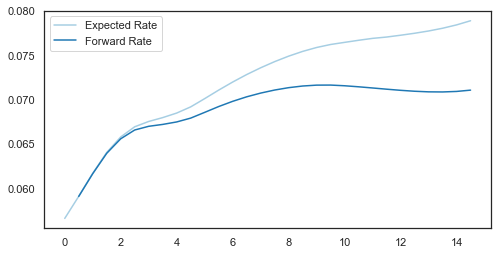

In [7]:
sns.set(style="white",palette="Paired")
plt.figure(figsize=(8, 4))
plt.plot(expected, label='Expected Rate')
plt.plot(forward, label='Forward Rate')
plt.legend()
plt.plot()

5. Using the tree, solve for the price of a five-year European call option on a two-year
bond with a coupon rate of four percent and where the strike price is 98. To do this,
you will need to solve for the price of the bond in five years for each of the 11 nodes
in the tree in five years. The price of a two-year bond at any time and node can be
computed from the values of D(0.5), D(1.0), D(1.5), and D(2.0) applicable to that
time and node.
Specifically, to figure out whether the call option is in the money in five years for,
say, the top node of the tree in five years, we need to compute the values of D(0.5),
D(1.0), D(1.5), and D(2.0) at that node. This is done by present valuing a cash
1
flow of $1 received at time 5.5 back to time 5, a cash flow of $1 received at time 6.0
back to time 5, a cash flow of $1 received at time 6.5 back to time 5, and a cash flow
of $1 received at time 7.0 back to time 5. From these D(T ) values for that node,
we can then compute the value of the two-year bond at the expiration date of the
call option at that node and compare its value to the strike price. This process is
repeated for each of the 11 nodes that are in the tree in five years. The call option
can then be valued by present valuing the option payoff back through the tree all
the way back to time zero.


In [8]:
class CallPrice:
    def __init__(self, _T, _K, _par, _c, _bdt):
        self.T = _T
        self.K = _K
        self.par = _par
        self.c = _c
        self.tree = _bdt

    def get_disc(self,note):
        r = self.tree[self.T].dropna()[note]
        d_05 = 1 / (1 + 0.5 * r)
    
        r_u = self.tree[self.T+0.5].dropna()[note]
        r_d = self.tree[self.T+0.5].dropna()[note+1]
        d_10 = (0.5 * (1 / (1 + r_u / 2)) + 0.5 * (1 / (1 + r_d / 2))) / (1 + 0.5 * r)

        r_uu = self.tree[self.T+1].dropna()[note]
        r_ud = self.tree[self.T+1].dropna()[note+1]
        r_dd = self.tree[self.T+1].dropna()[note+2]
        A = (0.5 * (1 / (1 + r_uu / 2)) + 0.5 * (1 / (1 + r_ud / 2))) / (1 + 0.5 * r_u)
        B = (0.5 * (1 / (1 + r_ud / 2)) + 0.5 * (1 / (1 + r_dd / 2))) / (1 + 0.5 * r_d)
        d_15 = (0.5 * A + 0.5 * B) / (1 + r / 2)

        r_uuu = self.tree[self.T+1.5].dropna()[note]
        r_uud = self.tree[self.T+1.5].dropna()[note + 1]
        r_udd = self.tree[self.T+1.5].dropna()[note + 2]
        r_ddd = self.tree[self.T+1.5].dropna()[note + 3]
        C = (0.5 * (1 / (1 + r_uuu / 2)) + 0.5 * (1 / (1 + r_uud / 2))) / (1 + 0.5* r_uu)
        D = (0.5 * (1 / (1 + r_uud / 2)) + 0.5 * (1 / (1 + r_udd / 2))) / (1 + 0.5* r_ud)
        E = (0.5 * (1 / (1 + r_udd / 2)) + 0.5 * (1 / (1 + r_ddd / 2))) / (1 + 0.5* r_dd)
        F = (0.5 * C + 0.5 * D) / (1 + r_u / 2) 
        G = (0.5 * D + 0.5 * E) / (1 + r_d / 2) 
        d_20 = (0.5 * F + 0.5 * G) / (1 + r / 2)

        return [d_05,d_10,d_15,d_20]
    
    def get_euro(self):
        price_ls = []
        for i in range(1, 12):
            disc_ls = self.get_disc(i)
            price_ls.append(self.c / 2 * np.sum(disc_ls) + self.par * disc_ls[3])

        call = price_ls - self.K*np.ones(11)
        call[call < 0] = 0
        call_price = 0
        
        for i in range(11):
            call_price += call[i]*binom.pmf(i,10,0.5)*disc_data.loc[5.0]
        
        return call_price.values[0]

In [9]:
callmodel = CallPrice(5,98,100,4,bdt_tree)
callmodel.get_euro()

0.2362842222901105